# SSD

This is to go through each important step of SSD.

Firstly, load the model. You only need to do this one time.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

import numpy as np
import os
os.chdir('..')
caffe_root = './'
import sys
sys.path.insert(0, caffe_root + 'python')
import time

import caffe
from caffe.proto import caffe_pb2

print caffe_root

./


In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()
# caffe.set_mode_cpu()
# We create a solver that fine-tunes from a previously trained network.

#model_def = '/home/youngwan/caffe/models/ResNet/KITTI/SSD_ResNet_26LBias_300x300_1st/deploy.prototxt'
#model_weights = '/home/youngwan/caffe/models/ResNet/KITTI/SSD_ResNet_26LBias_300x300_1st/ResNet_KITTI_SSD_ResNet_26LBias_300x300_iter_91602.caffemodel'
#solver = caffe.SGDSolver(caffe_root +'models/ResNet/KITTI/SSD_ResNet_26LBias_300x300_1st/solver.prototxt')
#solver.net.copy_from(caffe_root + 'models/ResNet/KITTI/SSD_ResNet_26LBias_300x300_1st/ResNet_KITTI_SSD_ResNet_26LBias_300x300_iter_91602.caffemodel')

#solver2 = caffe.SGDSolver(caffe_root +'models/ResNet/KITTI/SSD_ResNet_350x250_19L_conv4_350x250/solver.prototxt')
#solver2.net.copy_from(caffe_root + 'models/ResNet/KITTI/SSD_ResNet_350x250_19L_conv4_350x250/ResNet_KITTI_SSD_ResNet_350x250_19L_conv4_350x250_iter_100000.caffemodel')

solver = caffe.SGDSolver(caffe_root +'models/New/KITTI/SSD_Inception_Res_l2_ASP4_CIFAR10_Pretrained_350x250/solver.prototxt')
solver.net.copy_from(caffe_root + 'models/New/KITTI/SSD_Inception_Res_l2_ASP4_CIFAR10_Pretrained_350x250/KITTI_SSD_Inception_Res_l2_ASP4_CIFAR10_Pretrained_350x250_iter_100000.caffemodel')

In [4]:
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': solver.net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

#net = solver.net
net = solver.net

In [29]:
# Forward one step.
#solver.step(3)
solver.step(1)

Now let's see the annotated datum after one forward-backward step.

In [30]:
img_blob = net.blobs['data'].data
num_imgs = img_blob.shape[0]
img_width = img_blob.shape[3]
img_height = img_blob.shape[2]
label_blob = net.blobs['label'].data[0,0,:,:]
num_labels = label_blob.shape[0]

In [31]:
img_blob.shape #batch_size = 8

(16, 3, 250, 350)

In [32]:
net.blobs['label'].data.shape

(1, 1, 152, 8)

In [33]:
print num_labels

152


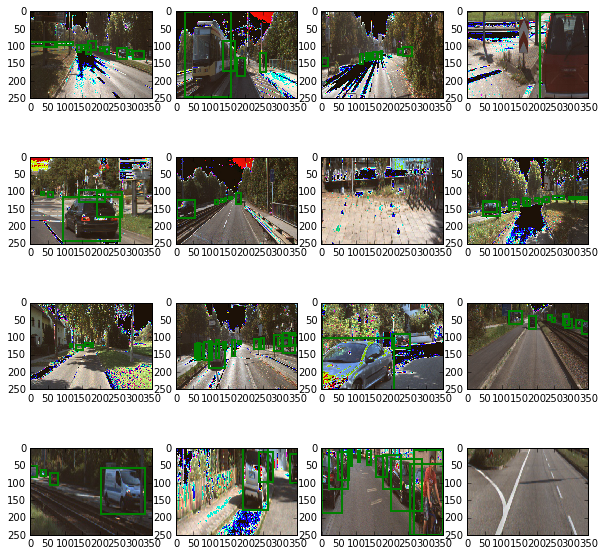

In [34]:
for i in xrange(num_imgs):
    img = transformer.deprocess('data', img_blob[i])
    plt.subplot(4, num_imgs/4, i + 1)
    plt.imshow(img)
    currentAxis = plt.gca()
    for j in xrange(num_labels):
        gt_bbox = label_blob[j, :]
        if gt_bbox[0] == i:
            xmin = gt_bbox[3] * img_width
            ymin = gt_bbox[4] * img_height
            xmax = gt_bbox[5] * img_width
            ymax = gt_bbox[6] * img_height
            coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))
            # print '{}: {}'.format(gt_bbox[0], gt_bbox[3:7])

In [35]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

Let's visualize the conv1_1's filters to make sure we have loaded a good pretrained model. Otherwise, it should plot random noise squares.

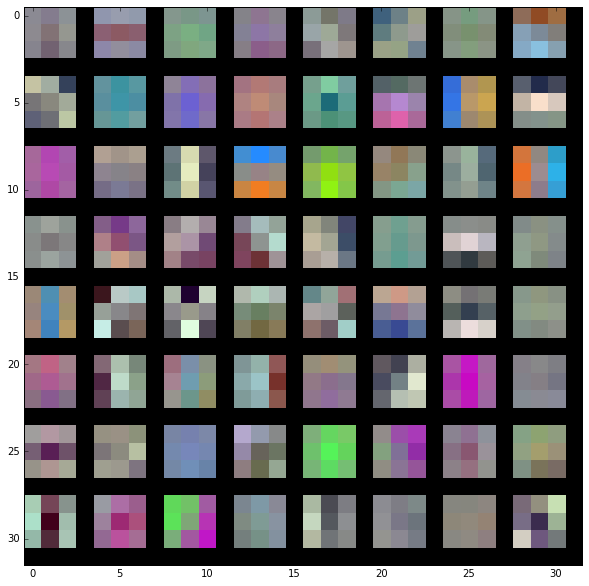

In [36]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

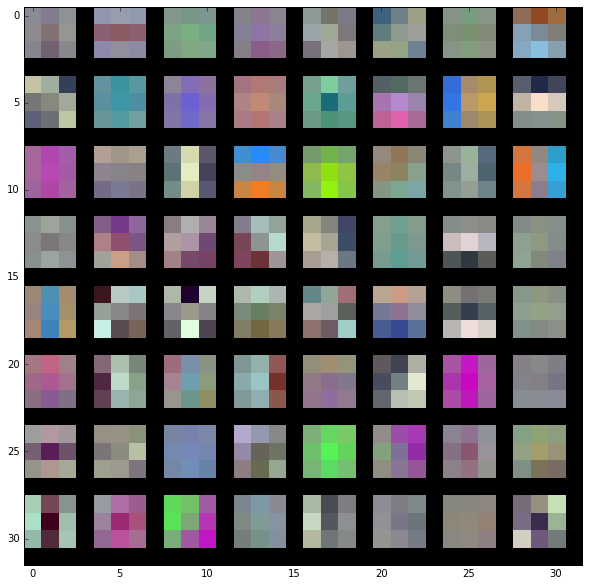

In [14]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

And let's visualize conv5_3 layer responses. You should see nicely pattern.

In [45]:
feat1 = net.blobs['conv1'].data[14, :]
feat2 = net.blobs['inception_3a'].data[14, :]
feat3 = net.blobs['res4b'].data[1, :]
feat4 = net.blobs['conv6_2'].data[1, :]
feat5 = net.blobs['conv7_2'].data[1, :]
feat6 = net.blobs['conv8_2'].data[1, :]

In [16]:
feat1.shape

(64, 125, 175)

In [17]:
feat2.shape

(256, 32, 44)

In [18]:
feat3.shape

(256, 16, 22)

In [19]:
feat4.shape

(512, 8, 11)

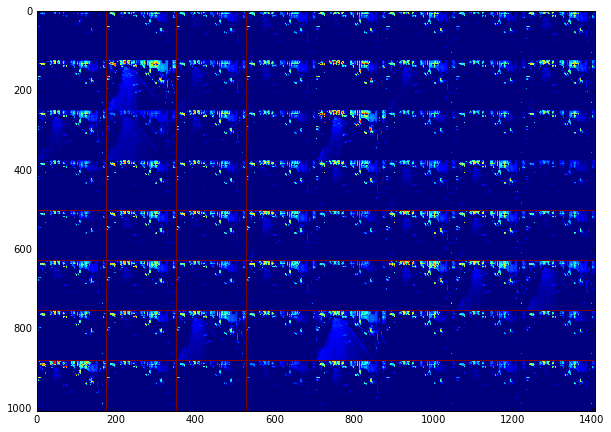

In [46]:

vis_square(feat1, padval=1)

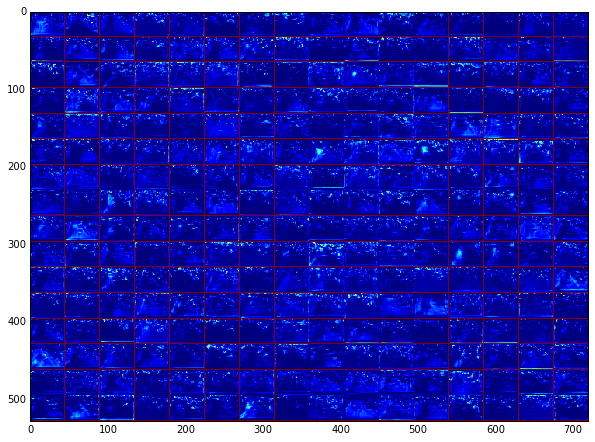

In [47]:
vis_square(feat2, padval=1)

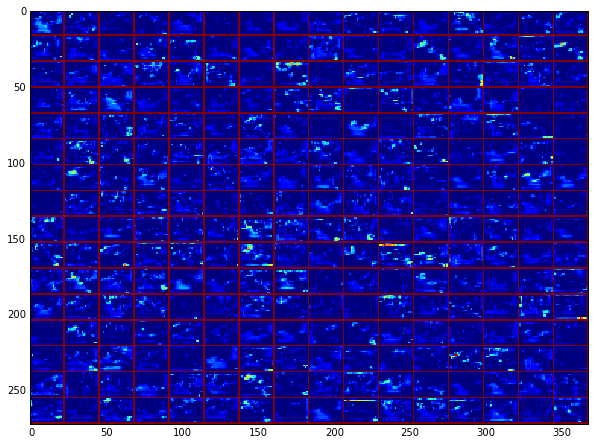

In [48]:

vis_square(feat3, padval=1)

Make sure that the PermuteLayer is doing the right thing.

In [ ]:
fc7_mbox_loc = net.blobs['fc7_mbox_loc'].data
print fc7_mbox_loc[0,:,1,2]

fc7_mbox_loc_perm = net.blobs['fc7_mbox_loc_perm'].data
print fc7_mbox_loc_perm[0,1,2,:]

Make sure the PriorBoxLayer generates the correct priors.

In [ ]:
priorbox = net.blobs['mbox_priorbox']
priorbox.data.shape

In [ ]:
img_blob = net.blobs['data'].data
#num_imgs = img_blob.shape[0]
num_imgs = 1
img_width = img_blob.shape[3]
img_height = img_blob.shape[2]

priorbox = net.blobs['mbox_priorbox'].data[0,0,:]
num_priors = priorbox.shape[0]

colors='rgbcmy'
for i in xrange(num_imgs):
    img = transformer.deprocess('data', img_blob[i])
    plt.subplot(1, num_imgs, i + 1)
    plt.imshow(img)
    currentAxis = plt.gca()
    for j in xrange(240,244):
    #for j in xrange(8999) :
        prior_bbox = priorbox[j*4:(j+1)*4]
        xmin = prior_bbox[0] * img_width
        ymin = prior_bbox[1] * img_height
        xmax = prior_bbox[2] * img_width
        ymax = prior_bbox[3] * img_height
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[j%4], linewidth=2))